Please run those two cells before running the Notebook!

As those plotting settings are standard throughout the book, we do not show them in the book every time we plot something.

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# feel free to modify, for example, change the context to "notebook"
sns.set_theme(context="talk", style="whitegrid", 
              palette="colorblind", color_codes=True, 
              rc={"figure.figsize": [12, 8]})

# Chapter 8 - Multi-Factor Models

이 장은 다양한 팩터 모델을 추정하는 것에 중점을 두고 있습니다. 팩터란 과거에 (미래의) 주식 수익률과 상관관계가 있었으며, 미래에도 동일한 예측 신호를 포함할 것으로 예상되는 변수나 속성을 말합니다. 이러한 리스크 팩터는 (예상되는) 수익률의 횡단면을 이해하는 도구로 간주될 수 있습니다. 그래서 여러 가지 팩터 모델이 포트폴리오나 자산의 초과 수익률(무위험 수익률을 초과한 수익률)을 하나 이상의 팩터를 사용해 설명하는 데 사용됩니다. 팩터는 이러한 초과 수익률의 원동력이 되는 리스크의 원천으로 생각할 수 있습니다. 각 팩터는 리스크 프리미엄을 지니고 있으며, 전체 포트폴리오나 자산의 수익률은 이러한 프리미엄들의 가중 평균으로 결정됩니다.

팩터 모델은 포트폴리오 관리에서 매우 중요한 역할을 합니다. 그 이유는 다음과 같습니다:

투자 포트폴리오에 추가할 수 있는 흥미로운 자산을 식별하는 데 사용될 수 있으며, 이는 더 성과가 좋은 포트폴리오로 이어질 수 있습니다. 포트폴리오나 자산이 팩터에 노출된 정도를 추정함으로써 더 나은 리스크 관리가 가능합니다. 새로운 리스크 팩터를 추가함으로써 발생하는 잠재적인 추가 가치를 평가하는 데 모델을 사용할 수 있습니다. 많은 자산의 수익률을 적은 수의 팩터로 요약하면 공분산 행렬을 추정하는 데 필요한 데이터의 양이 줄어들어 포트폴리오 최적화가 더 쉬워집니다. 포트폴리오 매니저의 성과를 평가할 때, 그 성과가 자산 선택과 거래 타이밍에 의한 것인지, 또는 알려진 수익률 동인(팩터)에 대한 노출에 의한 것인지 평가할 수 있습니다. 이 장의 끝에서는 가장 널리 사용되는 팩터 모델 중 일부를 구축할 것입니다. 우리는 가장 단순하지만 매우 인기 있는 1팩터 모델(해당 팩터가 시장 수익률일 때 자본 자산 가격 결정 모델과 동일함)부터 시작하여, 더 발전된 3팩터, 4팩터, 5팩터 모델을 추정하는 방법을 설명할 것입니다. 또한 이러한 팩터들이 무엇을 의미하는지 해석하고, 이들이 어떻게 구성되는지에 대한 고수준의 개요를 제공할 것입니다.

이 장에서 다루는 내용은 다음과 같습니다:

    - CAPM 추정
    - Fama-French 3팩터 모델 추정
    - 자산 포트폴리오에 대한 롤링 3팩터 모델 추정
    - 4팩터 및 5팩터 모델 추정
    - Fama-MacBeth 회귀를 사용한 횡단면 팩터 모델 추정

## 8.1 Estimating the CAPM

**자본자산가격결정모형(CAPM)**을 추정하고 베타 계수를 구하는 방법을 알아봅니다. 이 모델은 위험 자산과 시장 위험(체계적 또는 분산 불가능한 위험으로도 알려짐) 간의 관계를 나타냅니다. CAPM은 복잡한 요인 모형 위에 구축된 단일 요인 모형으로 간주될 수 있습니다.

CAPM은 다음과 같은 방정식으로 표현됩니다:

𝐸(𝑟𝑖) = 𝑟𝑓 + 𝛽𝑖(𝐸(𝑟𝑚) − 𝑟𝑓)

여기서, 𝐸(𝑟𝑖)는 자산 i에 대한 기대 수익률을 나타내고, 𝑟𝑓는 무위험 이자율(예: 정부 채권)입니다. 𝐸(𝑟𝑚)은 시장의 기대 수익률을 나타내며, 𝛽는 베타 계수입니다.

**베타**는 자산 수익률의 민감도를 시장에 대한 기준으로 해석할 수 있습니다. 아래는 계수에 대한 가능한 해석을 나타냅니다:

- 𝛽 < -1: 자산이 벤치마크와 반대 방향으로 움직이며 벤치마크보다 더 큰 폭으로 변동합니다.
- -1 < 𝛽 < 0: 자산이 벤치마크와 반대 방향으로 움직입니다.
- 𝛽 = 0: 자산의 가격 움직임과 시장 벤치마크 간에 상관관계가 없습니다.
- 0 < 𝛽 < 1: 자산이 시장과 같은 방향으로 움직이지만, 그 정도는 더 작습니다. 예시로는 일일 변동성에 크게 민감하지 않은 회사의 주식이 있습니다.
- 𝛽 = 1: 자산과 시장이 동일한 방향과 동일한 크기로 움직입니다.
- 𝛽 > 1: 자산이 시장과 같은 방향으로 움직이지만, 그 크기는 더 큽니다. 예시로는 일일 시장 뉴스에 매우 민감한 회사의 주식이 있을 수 있습니다.

CAPM은 다음과 같이 다시 표현될 수 있습니다:

𝐸(𝑟𝑖) - 𝑟𝑓 =  + 𝛽𝑖(𝐸(𝑟𝑚) − 𝑟𝑓)

이 방정식에서, 방정식의 왼쪽은 위험 프리미엄으로 해석될 수 있으며, 오른쪽은 시장 프리미엄을 포함하고 있습니다. 동일한 방정식은 다음과 같이 다시 정리될 수 있습니다:

𝛽 = cov(ri, rm) / var(rm)

여기서, \( R_i = E(r_i) - r_f \)이고, \( R_m = E(r_m) - r_f \)입니다.

--- 

위 내용은 CAPM(자본자산가격결정모형)에 대한 설명과 베타 계수의 해석을 다룹니다.

### How to do it...

1. Import the libraries:

In [6]:
import pandas as pd
import yfinance as yf
# import statsmodels as sm
import statsmodels.api as sm
from statsmodels.tools import add_constant

2. Specify the risky asset, the benchmark, and the time horizon:

In [7]:
RISKY_ASSET = "AMZN"
MARKET_BENCHMARK = "^GSPC"
START_DATE = "2016-01-01"
END_DATE = "2020-12-31"

3. Download data from Yahoo Finance:

In [8]:
df = yf.download([RISKY_ASSET, MARKET_BENCHMARK],
                 start=START_DATE,
                 end=END_DATE,
                #  adjusted=True,
                 progress=False)

print(f'Downloaded {df.shape[0]} rows of data.')

Downloaded 1259 rows of data.


4. Resample to monthly data and calculate simple returns:

In [9]:
X = (
    df["Adj Close"]
    .rename(columns={RISKY_ASSET: "asset", 
                     MARKET_BENCHMARK: "market"})
    .resample("ME")
    .last()
    .pct_change()
    .dropna()
)
X.head()

,asset,market
Date,,
2016-01-31,-0.131515,-0.050735
2016-02-29,-0.058739,-0.004128
2016-03-31,0.074423,0.065991
2016-04-30,0.111094,0.002699
2016-05-31,0.095817,0.015325


5. Calculate beta using the covariance approach: 

In [10]:
covariance = X.cov().iloc[0,1]
benchmark_variance = X.market.var()
beta = covariance / benchmark_variance
beta

1.2034611811489746

6. Prepare the input and estimate CAPM as a linear regression:

OLS(Ordinary Least Squares)

In [11]:
# separate target
y = X.pop("asset")

# add constant
X = sm.add_constant(X)

# define and fit the regression model 
capm_model = sm.OLS(y, X).fit()

# print results 
print(capm_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  asset   R-squared:                       0.408
Model:                            OLS   Adj. R-squared:                  0.398
Method:                 Least Squares   F-statistic:                     40.05
Date:                Mon, 30 Sep 2024   Prob (F-statistic):           3.89e-08
Time:                        17:14:20   Log-Likelihood:                 80.639
No. Observations:                  60   AIC:                            -157.3
Df Residuals:                      58   BIC:                            -153.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0167      0.009      1.953      0.0

Or, using the formula notation:

In [12]:
import statsmodels.formula.api as smf

# rerun step 4 to have a DF with columns: `asset` and `market`
X = df["Adj Close"].rename(columns={RISKY_ASSET: "asset", 
                                    MARKET_BENCHMARK: "market"}) \
                   .resample("ME") \
                   .last() \
                   .pct_change() \
                   .dropna()

# define and fit the regression model 
capm_model = smf.ols(formula="asset ~ market", data=X).fit()

# print results 
print(capm_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  asset   R-squared:                       0.408
Model:                            OLS   Adj. R-squared:                  0.398
Method:                 Least Squares   F-statistic:                     40.05
Date:                Mon, 30 Sep 2024   Prob (F-statistic):           3.89e-08
Time:                        17:14:21   Log-Likelihood:                 80.639
No. Observations:                  60   AIC:                            -157.3
Df Residuals:                      58   BIC:                            -153.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0167      0.009      1.953      0.0

이 결과는 베타(여기서는 시장으로 표시됨)가 1.2와 같다는 것을 나타냅니다. 이는 아마존의 수익률이 시장(S&P 500을 기준으로 함)보다 20% 더 변동성이 크다는 의미입니다. 다시 말해, 아마존의 초과 수익률은 시장의 초과 수익률에 비해 1.2배 움직일 것으로 예상된다는 뜻입니다. 절편의 값은 비교적 작으며 5% 유의 수준에서 통계적으로 유의미하지 않습니다.

### There's more

#### Risk-free rate (13 Week Treasury Bill)

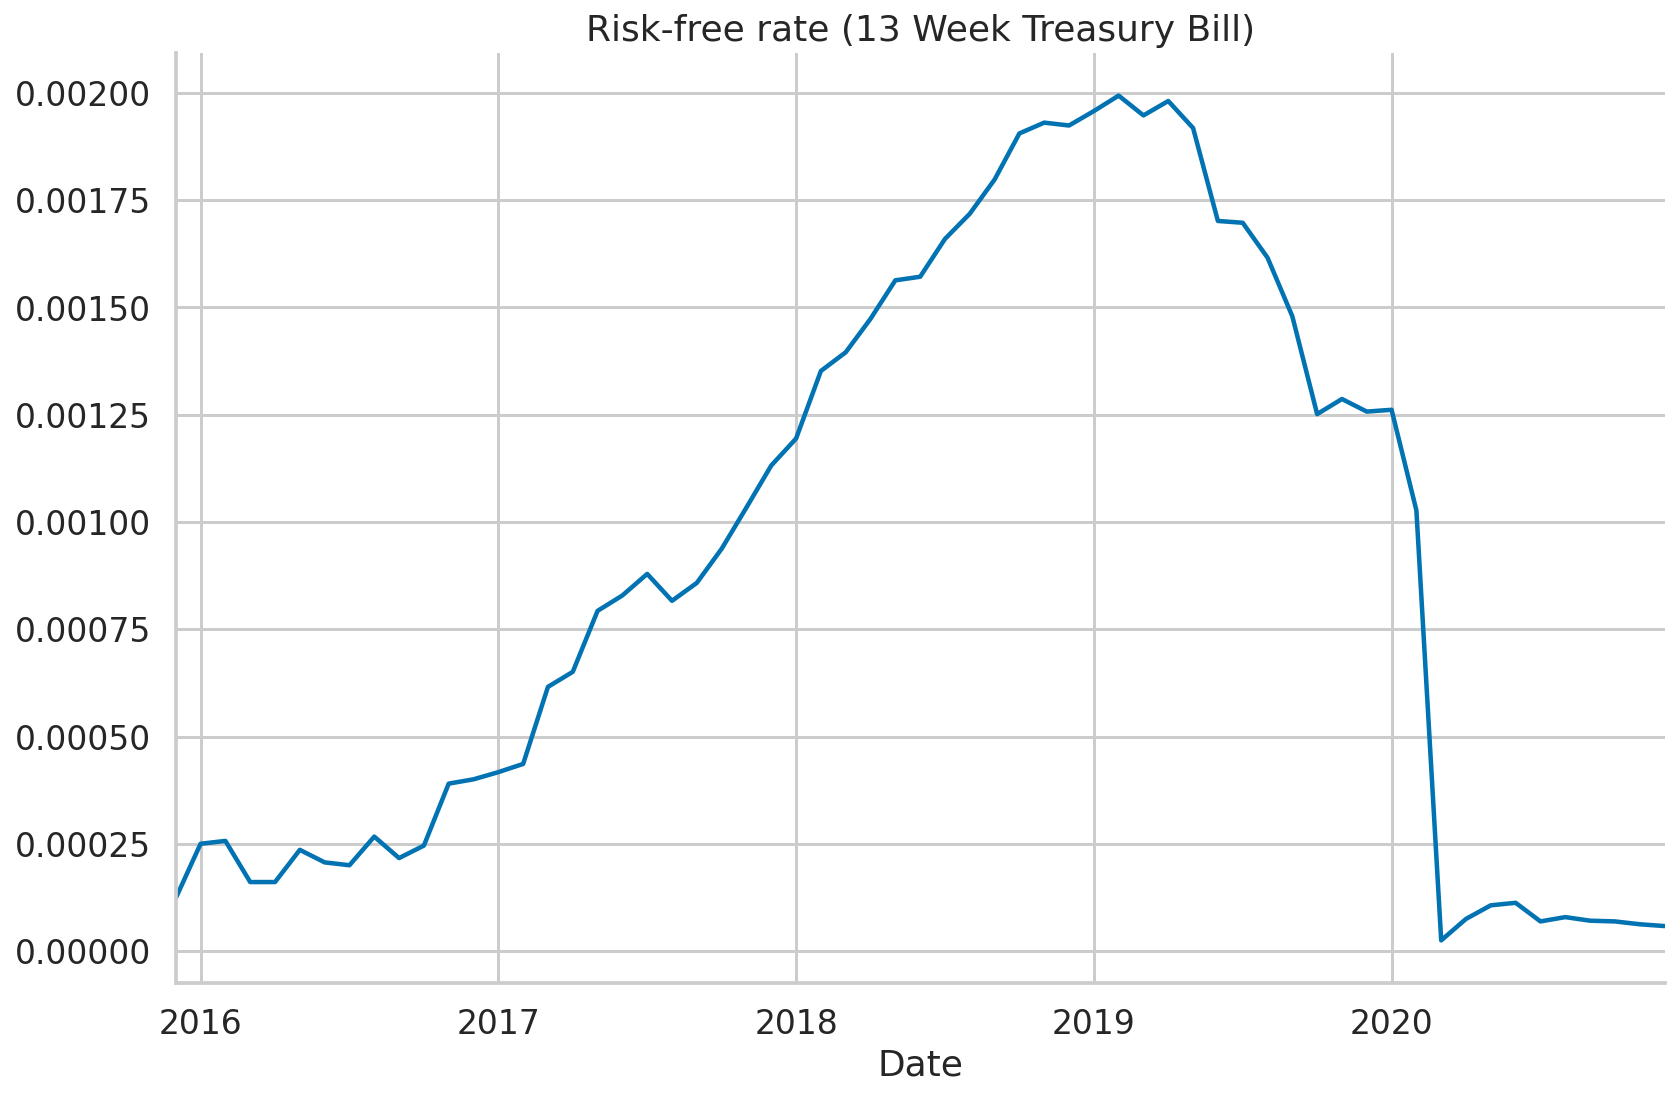

In [13]:
# period length in days
N_DAYS = 90

# download data from Yahoo finance
df_rf = yf.download("^IRX",
                    start=START_DATE,
                    end=END_DATE,
                    progress=False)

# resample to monthly by taking last value from each month
rf = df_rf.resample("ME").last().Close / 100

# calculate the corresponding daily risk-free return  
rf = ( 1 / (1 - rf * N_DAYS / 360) )**(1 / N_DAYS)  

# convert to monthly and subtract 1
rf = (rf ** 30) - 1 

# plot the risk-free rate
rf.plot(title="Risk-free rate (13 Week Treasury Bill)")

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_9_2", dpi=200)

#### Risk-free rate (3-Month Treasury Bill)

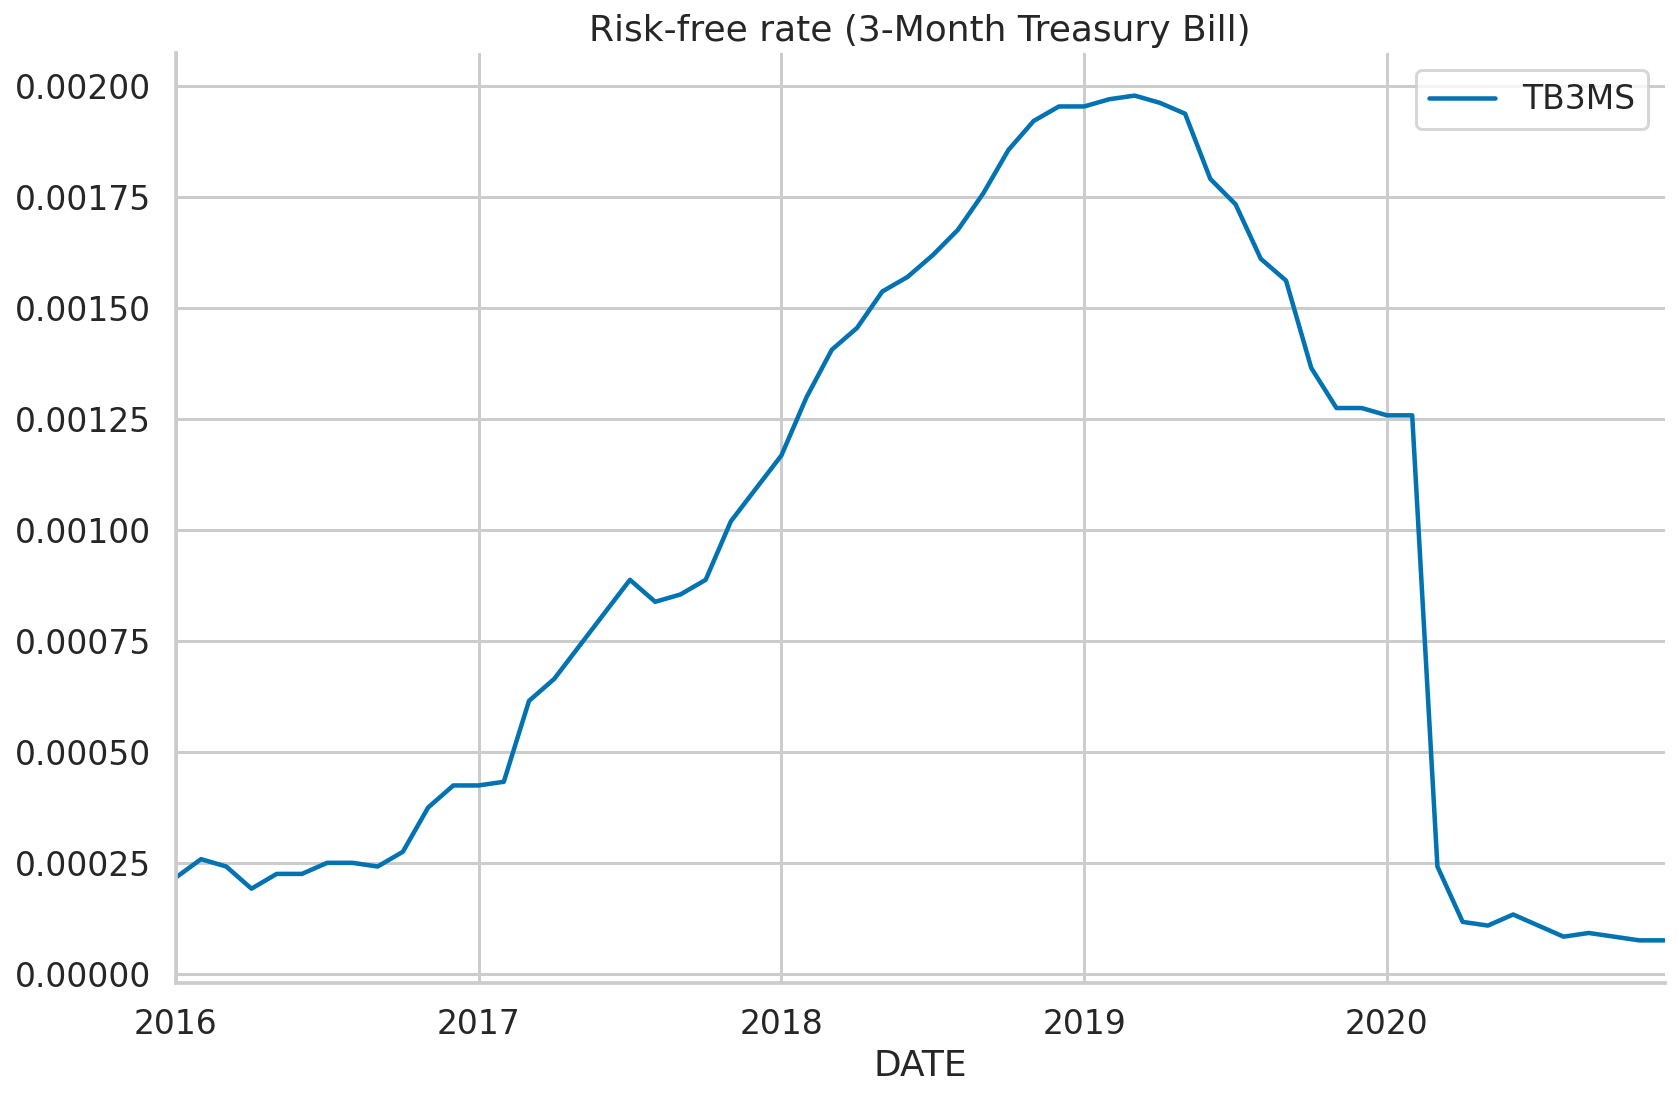

In [14]:
import pandas_datareader.data as web

# download the data 
rf = web.DataReader(
    "TB3MS", "fred", start=START_DATE, end=END_DATE
)

# convert to monthly
rf = (1 + (rf / 100)) ** (1 / 12) - 1

# plot the risk-free rate
rf.plot(title="Risk-free rate (3-Month Treasury Bill)")

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_9_3", dpi=200)

## 8.2 Estimating the Fama-French three-factor model

시장 요인 (MKT): 이는 시장의 초과 수익률을 측정하며, CAPM에서의 것과 유사합니다.
규모 요인 (SMB; Small Minus Big): 이는 소형 시가총액 주식의 초과 수익률을 대형 시가총액 주식에 비해 측정합니다.
가치 요인 (HML; High Minus Low): 이는 가치주가 성장주에 비해 갖는 초과 수익률을 측정합니다. 가치주는 장부가 대비 시장가 비율이 높고, 성장주는 이 비율이 낮은 것이 특징입니다.

### How to do it...

1. Import the libraries:

In [15]:
import pandas as pd
import yfinance as yf
import statsmodels.formula.api as smf
import pandas_datareader.data as web

2. Define parameters:

In [16]:
RISKY_ASSET = "AAPL"
START_DATE = "2016-01-01"
END_DATE = "2020-12-31"

3. Download the dataset containing the risk factors:

In [17]:
ff_dict = web.DataReader("F-F_Research_Data_Factors", 
                         "famafrench", 
                         start=START_DATE,
                         end=END_DATE)

In [18]:
ff_dict.keys()

dict_keys([0, 1, 'DESCR'])

In [19]:
print(ff_dict['DESCR'])

F-F Research Data Factors
-------------------------

This file was created by CMPT_ME_BEME_RETS using the 202407 CRSP database. The 1-month TBill rate data until 202405 are from Ibbotson Associates. Starting from 202406, the 1-month TBill rate is from ICE BofA US 1-Month Treasury Bill Index. Copyright 2024 Kenneth R. French

  0 : (60 rows x 4 cols)
  1 : Annual Factors: January-December (5 rows x 4 cols)


4. Select the appropriate dataset and divide the values by 100:

In [20]:
factor_3_df = ff_dict[0].rename(columns={"Mkt-RF": "MKT"}) \
                        .div(100)

factor_3_df.head()

,MKT,SMB,HML,RF
Date,,,,
2016-01,-0.0577,-0.0342,0.0209,0.0001
2016-02,-0.0007,0.0074,-0.0057,0.0002
2016-03,0.0696,0.0082,0.0119,0.0002
2016-04,0.0091,0.0076,0.0328,0.0001
2016-05,0.0178,-0.0017,-0.0166,0.0001


5. Download the prices of the risky asset:

In [21]:
asset_df = yf.download(RISKY_ASSET,
                       start=START_DATE,
                       end=END_DATE,
                    #    adjusted=True,
                       progress=False)

print(f"Downloaded {asset_df.shape[0]} rows of data.")

Downloaded 1259 rows of data.


6. Calculate monthly returns on the risky asset:

In [22]:
y = asset_df["Adj Close"].resample("M") \
                         .last() \
                         .pct_change() \
                         .dropna()

y.index = y.index.to_period("m")
y.name = "rtn"
y.head()

Date
2016-01   -0.075242
2016-02   -0.001287
2016-03    0.127210
2016-04   -0.139921
2016-05    0.071773
Freq: M, Name: rtn, dtype: float64

7. Merge the datasets and calculate excess returns:

In [23]:
factor_3_df = factor_3_df.join(y)
factor_3_df["excess_rtn"] = (
    factor_3_df["rtn"] - factor_3_df["RF"]
)
factor_3_df.head()

,MKT,SMB,HML,RF,rtn,excess_rtn
Date,,,,,,
2016-01,-0.0577,-0.0342,0.0209,0.0001,-0.075242,-0.075342
2016-02,-0.0007,0.0074,-0.0057,0.0002,-0.001287,-0.001487
2016-03,0.0696,0.0082,0.0119,0.0002,0.127210,0.127010
2016-04,0.0091,0.0076,0.0328,0.0001,-0.139921,-0.140021
2016-05,0.0178,-0.0017,-0.0166,0.0001,0.071773,0.071673


8. Estimate the three-factor model:

In [24]:
# define and fit the regression model 
ff_model = smf.ols(formula="excess_rtn ~ MKT + SMB + HML", 
                   data=factor_3_df).fit()

# print results 
print(ff_model.summary())

                            OLS Regression Results                            
Dep. Variable:             excess_rtn   R-squared:                       0.506
Model:                            OLS   Adj. R-squared:                  0.480
Method:                 Least Squares   F-statistic:                     19.15
Date:                Mon, 30 Sep 2024   Prob (F-statistic):           1.14e-08
Time:                        17:14:41   Log-Likelihood:                 82.838
No. Observations:                  60   AIC:                            -157.7
Df Residuals:                      56   BIC:                            -149.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0084      0.009      0.956      0.3

세 가지 요인 모형의 결과를 해석할 때는 두 가지 이슈에 주의해야 합니다:

    - 절편이 양수이며 통계적으로 유의한지 여부
    - 어떤 요인이 통계적으로 유의하며, 그 방향이 과거 연구 결과(예: 문헌 연구에 기반) 또는 우리의 가정과 일치하는지 여부
    
우리의 경우, 절편은 양수이지만 5% 유의 수준에서 통계적으로 유의하지 않습니다. 위험 요인 중에서는 SMB 요인만 유의하지 않습니다. 그러나 요인들과 그 영향 방향에 대한 가설을 세우기 위해서는 철저한 문헌 연구가 필요합니다.

또한 회귀 요약에서 제시된 F-통계를 살펴볼 수 있는데, 이는 회귀 모형의 공동 유의성을 테스트합니다. 영가설은 절편을 제외한 모든 특징(여기서는 요인)의 계수가 0이라는 것을 주장합니다. 관련된 p-값이 0.05보다 훨씬 낮다는 것을 확인할 수 있으며, 이는 5% 유의 수준에서 영가설을 기각할 근거가 된다는 것을 의미합니다.

### There's more

Print available datasets (here only first 5):

In [25]:
from pandas_datareader.famafrench import get_available_datasets

get_available_datasets()[:5]

['F-F_Research_Data_Factors',
 'F-F_Research_Data_Factors_weekly',
 'F-F_Research_Data_Factors_daily',
 'F-F_Research_Data_5_Factors_2x3',
 'F-F_Research_Data_5_Factors_2x3_daily']

### Bonus

1. Download data from prof. French's website:

To do so, we used the fact that we can execute bash commands in Jupyter Notebooks by preceding them with `!`. First, we downloaded the file using wget and then unzipped it using unzip. There are also ways to do this in Python only, but this seemed like a good place to introduce the possibility of mixing up bash script into the Notebooks. The link to the monthly data is always the same, and the file is updated every month. 


In [1]:
# # download the zip file from Prof. French's website
# !wget http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_CSV.zip

# # unpack the zip file
# !unzip -a F-F_Research_Data_Factors_CSV.zip

# # remove the zip file
# !rm F-F_Research_Data_Factors_CSV.zip

2. Load data from the source CSV file and keep only the monthly data:

In [3]:
# # load data from CSV
# factor_3_df = pd.read_csv("F-F_Research_Data_Factors.csv", skiprows=3)

# # identify where the annual data starts
# STR_TO_MATCH = " Annual Factors: January-December "
# indices = factor_3_df.iloc[:, 0] == STR_TO_MATCH
# start_of_annual = factor_3_df[indices].index[0]

# # keep only monthly data
# factor_3_df = factor_3_df[factor_3_df.index < start_of_annual]

3. Rename columns of the DataFrame, set a datetime index and filter by dates:

In [25]:
# rename columns
factor_3_df.columns = ["date", "mkt", "smb", "hml", "rf"]

# convert strings to datetime
factor_3_df["date"] = (
    pd.to_datetime(factor_3_df["date"], format="%Y%m")
    .dt.strftime("%Y-%m")
)

# set index
factor_3_df = factor_3_df.set_index("date")

# filter only required dates
factor_3_df = factor_3_df.loc[START_DATE:END_DATE]

4. Convert the values to numeric and divide by 100:

In [26]:
factor_3_df = factor_3_df.apply(pd.to_numeric, 
                            errors="coerce") \
                     .div(100)
factor_3_df.head()

,mkt,smb,hml,rf
date,,,,
2016-02,-0.0007,0.0079,-0.0050,0.0002
2016-03,0.0696,0.0087,0.0116,0.0002
2016-04,0.0092,0.0069,0.0326,0.0001
2016-05,0.0178,-0.0027,-0.0181,0.0001
2016-06,-0.0005,0.0065,-0.0147,0.0002


## 8.3 Estimating the rolling three-factor model on a portfolio of assets

이 설명에서는 롤링 방식으로 3요인 모형을 추정하는 방법을 배웁니다. 롤링 방식이란, 항상 일정한 크기의 추정 창(이 경우 60개월)을 고려하고 이를 전체 데이터셋에서 한 번에 한 기간씩 이동시키는 것을 의미합니다. 이러한 실험을 수행하는 잠재적인 이유는 결과의 안정성을 테스트하기 위해서입니다. 대안으로는 이 실험에서 확장되는 창을 사용할 수도 있습니다.

이전 설명들과 달리 이번에는 단일 자산 대신 포트폴리오 수익률을 사용합니다. 간단하게 하기 위해, 우리가 사용하는 할당 전략은 아마존, 구글, 애플, 마이크로소프트의 각 주식에 포트폴리오 총 가치의 동일한 비율을 할당한다고 가정합니다. 이 실험에서는 2010년부터 2020년까지의 주가 데이터를 사용합니다.

### How to do it...

1. Import the libraries:

In [26]:
import pandas as pd
import numpy as np
import yfinance as yf
import statsmodels.formula.api as smf
import pandas_datareader.data as web

2. Define the parameters:

In [27]:
ASSETS = ["AMZN", "GOOG", "AAPL", "MSFT"]
WEIGHTS = [0.25, 0.25, 0.25, 0.25]
START_DATE = "2010-01-01"
END_DATE = "2020-12-31"

3. Download the factor related data:

In [28]:
factor_3_df = web.DataReader("F-F_Research_Data_Factors", 
                             "famafrench", 
                             start=START_DATE,
                             end=END_DATE)[0]
factor_3_df = factor_3_df.div(100)

4. Download the prices of risky assets from Yahoo Finance:

In [29]:
asset_df = yf.download(ASSETS,
                       start=START_DATE,
                       end=END_DATE,
                    #    adjusted=True,
                       progress=False)

print(f"Downloaded {asset_df.shape[0]} rows of data.")

Downloaded 2769 rows of data.


5. Calculate the monthly returns on the risky assets:

In [30]:
asset_df = asset_df["Adj Close"].resample("M") \
                                .last() \
                                .pct_change() \
                                .dropna()
# reformat index for joining
asset_df.index = asset_df.index.to_period("m")

6. Calculate the portfolio returns:

In [31]:
asset_df["portfolio_returns"] = np.matmul(
    asset_df[ASSETS].values, 
    WEIGHTS
)
asset_df.head()

,AAPL,AMZN,GOOG,MSFT,portfolio_returns
Date,,,,,
2010-01,-0.088596,-0.067722,-0.145231,-0.075459,-0.094252
2010-02,0.065396,-0.055897,-0.005925,0.022146,0.006430
2010-03,0.148470,0.146706,0.076538,0.021626,0.098335
2010-04,0.111021,0.009796,-0.073036,0.042677,0.022615
2010-05,-0.016125,-0.084902,-0.076222,-0.151395,-0.082161


In [32]:
# asset_df.plot();

7. Merge the datasets:

In [33]:
factor_3_df = asset_df.join(factor_3_df).drop(ASSETS, axis=1)
factor_3_df.columns = ["portf_rtn", "mkt", "smb", "hml", "rf"]
factor_3_df["portf_ex_rtn"] = (
    factor_3_df["portf_rtn"] - factor_3_df["rf"]
)

8. Define a function for the rolling n-factor model

In [34]:
def rolling_factor_model(input_data, formula, window_size):
    """
    Function for estimating the Fama-French (n-factor) model using a rolling window of fixed size.
    
    Parameters
    ------------
    input_data : pd.DataFrame
        A DataFrame containing the factors and asset/portfolio returns
    formula : str
        `statsmodels` compatible formula representing the OLS regression  
    window_size : int
        Rolling window length.
    
    Returns
    -----------
    coeffs_df : pd.DataFrame
        DataFrame containing the intercept and the three factors for each iteration.
    """

    coeffs = []

    for start_ind in range(len(input_data) - window_size + 1):        
        end_ind = start_ind + window_size

        # define and fit the regression model 
        ff_model = smf.ols(
            formula=formula, 
            data=input_data[start_ind:end_ind]
        ).fit()
   
        # store coefficients
        coeffs.append(ff_model.params)
    
    coeffs_df = pd.DataFrame(
        coeffs, 
        index=input_data.index[window_size - 1:]
    )

    return coeffs_df

9. Estimate the rolling three-factor model and plot the results:

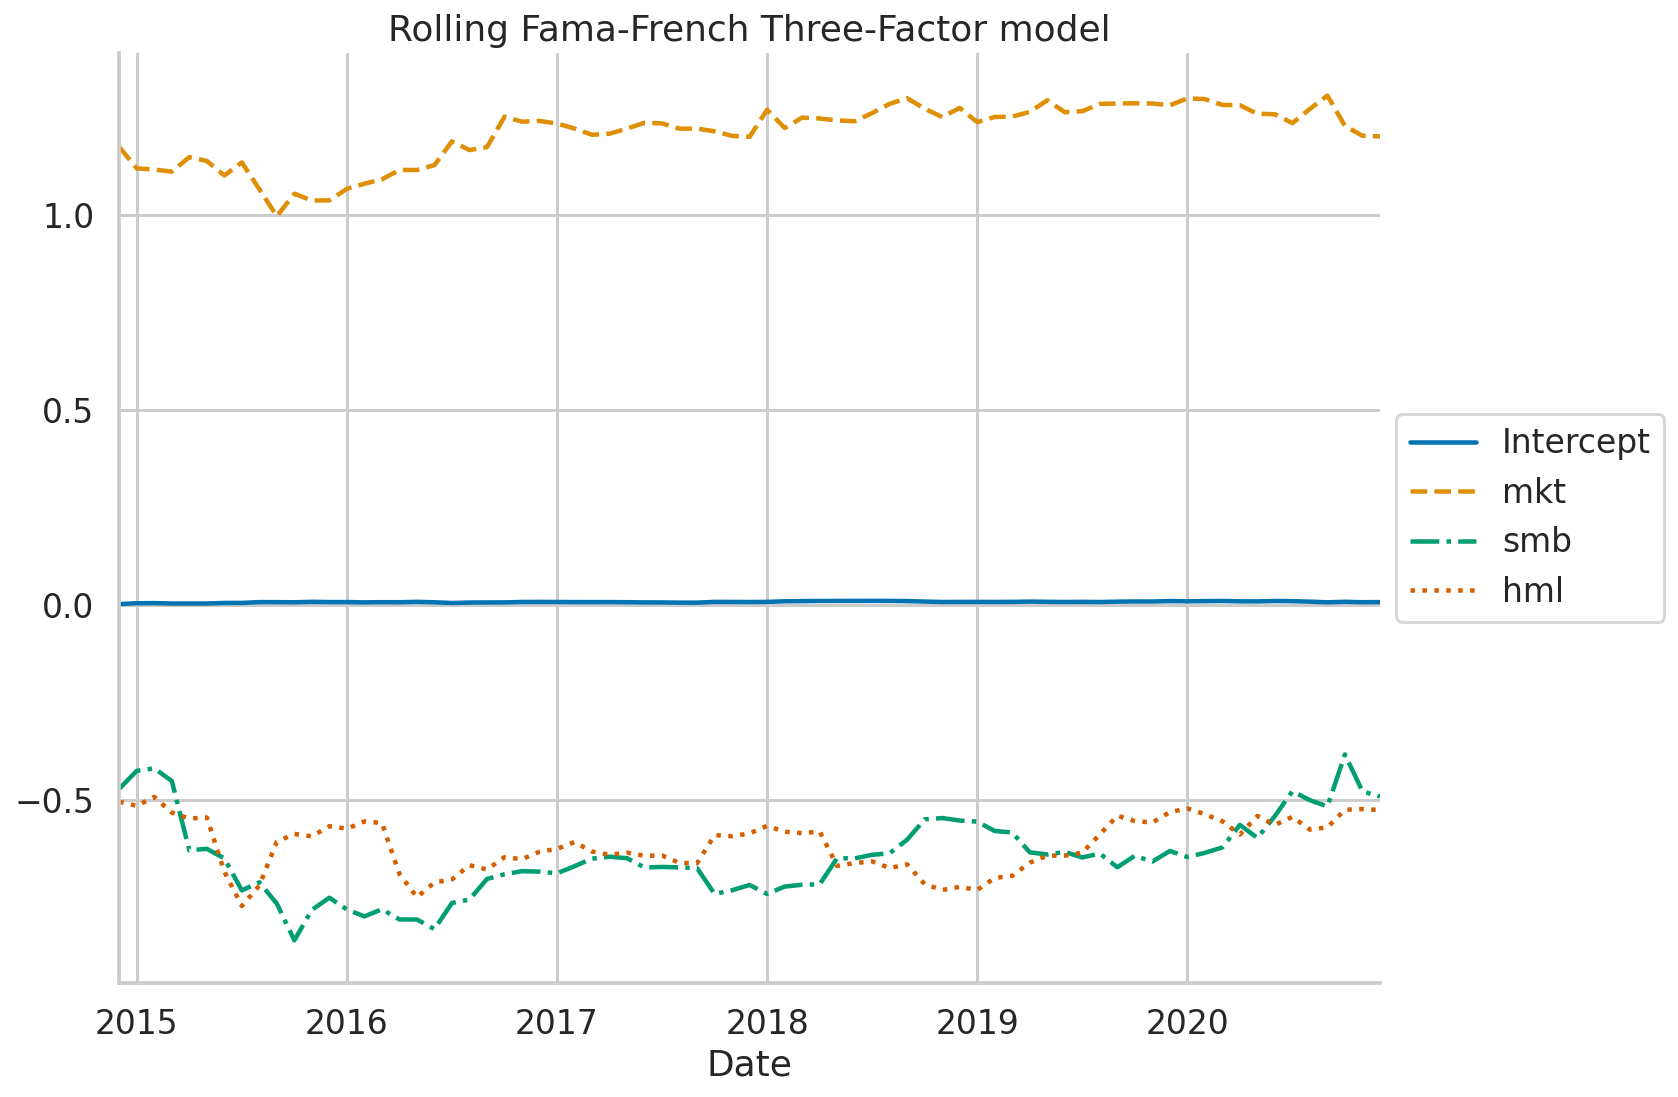

In [35]:
MODEL_FORMULA = "portf_ex_rtn ~ mkt + smb + hml"
results_df = rolling_factor_model(factor_3_df, 
                                  MODEL_FORMULA, 
                                  window_size=60)
(
    results_df
    .plot(title = "Rolling Fama-French Three-Factor model",
          style=["-", "--", "-.", ":"])
    .legend(loc="center left",bbox_to_anchor=(1.0, 0.5))
)

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_9_6", dpi=200)

이전 플롯을 검토해 보면 다음과 같은 점을 확인할 수 있습니다:

절편은 거의 일정하며 0에 매우 가깝습니다.
요인들 간에는 약간의 변동성이 있지만, 갑작스러운 반전이나 예상치 못한 급등은 없습니다.

## 8.4 Estimating the four- and five-factor models

이 설명에서는 Fama-French 3요인 모형의 두 가지 확장을 구현합니다.

첫 번째는 Carhart의 4요인 모형입니다. 이 확장의 기본 가정은 단기간 내에 승자 주식은 승자로 남고, 패자 주식은 패자로 남는다는 것입니다. 승자와 패자를 분류하는 기준으로는 예를 들어 지난 12개월간의 누적 총 수익률을 사용할 수 있습니다. 두 그룹을 식별한 후, 승자 주식을 매수(Long)하고 패자 주식을 매도(Short)하는 전략을 특정 보유 기간 동안 실행할 수 있습니다.

모멘텀 요인(WML; Winners Minus Losers)은 지난 12개월 동안 승자 주식이 패자 주식에 비해 갖는 초과 수익률을 측정합니다. (모멘텀 요인 계산에 대한 참조는 이 설명의 '참고' 섹션을 참고하십시오.)


두 번째 확장은 Fama-French의 5요인 모형입니다. Fama와 French는 기존의 3요인 모형에 두 가지 요인을 추가하여 확장했습니다:

수익성 요인 (RMW; Robust Minus Weak): 수익성이 높은 기업(강한 수익성)이 수익성이 낮은 기업(약한 수익성)에 비해 갖는 초과 수익률을 측정합니다.
투자 요인 (CMA; Conservative Minus Aggressive): 보수적인 투자 정책을 가진 기업(투자가 적은 기업)이 더 공격적인 투자 정책을 가진 기업(투자가 많은 기업)에 비해 갖는 초과 수익률을 측정합니다.
이 두 가지 요인은 기존의 시장 요인, 규모 요인, 가치 요인에 추가되어 더 넓은 범위에서 주식 수익률을 설명합니다.


### How to do it...

1. Import the libraries:

In [36]:
import pandas as pd
import yfinance as yf
import statsmodels.formula.api as smf
import pandas_datareader.data as web

2. Specify the risky asset and the time horizon:

In [37]:
RISKY_ASSET = "AMZN"
START_DATE = "2016-01-01"
END_DATE = "2020-12-31"

3. Download the risk factors from prof. French's website:

In [38]:
# three factors 
factor_3_df = web.DataReader("F-F_Research_Data_Factors", 
                             "famafrench", 
                             start=START_DATE,
                             end=END_DATE)[0]

# momentum factor
momentum_df = web.DataReader("F-F_Momentum_Factor", 
                             "famafrench", 
                             start=START_DATE,
                             end=END_DATE)[0]
      
# five factors
factor_5_df = web.DataReader("F-F_Research_Data_5_Factors_2x3", 
                             "famafrench", 
                             start=START_DATE,
                             end=END_DATE)[0]

4. Download the data of the risky asset from Yahoo Finance:

In [39]:
asset_df = yf.download(RISKY_ASSET,
                       start=START_DATE,
                       end=END_DATE,
                    #    adjusted=True,
                       progress=False)

print(f"Downloaded {asset_df.shape[0]} rows of data.")

Downloaded 1259 rows of data.


5. Calculate monthly returns:

In [40]:
y = asset_df["Adj Close"].resample("M") \
                         .last() \
                         .pct_change() \
                         .dropna()

y.index = y.index.to_period("m")
y.name = "rtn"

6. Merge the datasets for the four-factor models:

In [41]:
# join all datasets on the index
factor_4_df = factor_3_df.join(momentum_df).join(y)

# rename columns
factor_4_df.columns = ["mkt", "smb", "hml", "rf", "mom", "rtn"]

# divide everything (except returns) by 100
factor_4_df.loc[:, factor_4_df.columns != "rtn"] /= 100

# calculate excess returns
factor_4_df["excess_rtn"] = (
    factor_4_df["rtn"] - factor_4_df["rf"]
)

factor_4_df.head()

,mkt,smb,hml,rf,mom,rtn,excess_rtn
Date,,,,,,,
2016-01,-0.0577,-0.0342,0.0209,0.0001,0.0144,-0.131515,-0.131615
2016-02,-0.0007,0.0074,-0.0057,0.0002,-0.0438,-0.058739,-0.058939
2016-03,0.0696,0.0082,0.0119,0.0002,-0.0501,0.074423,0.074223
2016-04,0.0091,0.0076,0.0328,0.0001,-0.0602,0.111094,0.110994
2016-05,0.0178,-0.0017,-0.0166,0.0001,0.0143,0.095817,0.095717


7. Merge the datasets for the five-factor models:

In [42]:
# join all datasets on the index
factor_5_df = factor_5_df.join(y)

# rename columns
factor_5_df.columns = [
    "mkt", "smb", "hml", "rmw", "cma", "rf", "rtn"
]

# divide everything (except returns) by 100
factor_5_df.loc[:, factor_5_df.columns != "rtn"] /= 100

# calculate excess returns
factor_5_df["excess_rtn"] = (
    factor_5_df["rtn"] - factor_5_df["rf"]
)

factor_5_df.head()

,mkt,smb,hml,rmw,cma,rf,rtn,excess_rtn
Date,,,,,,,,
2016-01,-0.0577,-0.0347,0.0209,0.0281,0.0307,0.0001,-0.131515,-0.131615
2016-02,-0.0007,0.0088,-0.0057,0.0325,0.0202,0.0002,-0.058739,-0.058939
2016-03,0.0696,0.0107,0.0119,0.0077,-0.0008,0.0002,0.074423,0.074223
2016-04,0.0091,0.0123,0.0328,-0.0297,0.0190,0.0001,0.111094,0.110994
2016-05,0.0178,-0.0061,-0.0166,-0.0109,-0.0249,0.0001,0.095817,0.095717


8. Estimate the four-factor model:

In [43]:
four_factor_model = smf.ols(
    formula="excess_rtn ~ mkt + smb + hml + mom", 
    data=factor_4_df
).fit()

print(four_factor_model.summary())

                            OLS Regression Results                            
Dep. Variable:             excess_rtn   R-squared:                       0.564
Model:                            OLS   Adj. R-squared:                  0.532
Method:                 Least Squares   F-statistic:                     17.79
Date:                Mon, 30 Sep 2024   Prob (F-statistic):           2.01e-09
Time:                        17:15:08   Log-Likelihood:                 89.722
No. Observations:                  60   AIC:                            -169.4
Df Residuals:                      55   BIC:                            -159.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0055      0.008      0.692      0.4

9. Estimate the five-factor model:

In [44]:
five_factor_model = smf.ols(
    formula="excess_rtn ~ mkt + smb + hml + rmw + cma", 
    data=factor_5_df
).fit()

print(five_factor_model.summary())

                            OLS Regression Results                            
Dep. Variable:             excess_rtn   R-squared:                       0.610
Model:                            OLS   Adj. R-squared:                  0.574
Method:                 Least Squares   F-statistic:                     16.89
Date:                Mon, 30 Sep 2024   Prob (F-statistic):           5.09e-10
Time:                        17:15:09   Log-Likelihood:                 93.061
No. Observations:                  60   AIC:                            -174.1
Df Residuals:                      54   BIC:                            -161.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0058      0.008      0.767      0.4

5요인 모형에 따르면, 아마존의 초과 수익률은 대부분의 요인(시장 요인을 제외한 모든 요인)에 부정적으로 노출되어 있습니다. 여기에서 계수 해석의 예시를 제공합니다: 시장 요인이 1%포인트 증가하면, 아마존의 초과 수익률이 0.015%포인트 증가합니다. 다시 말해, 시장 요인이 1%의 수익률을 기록하면, 아마존 주식이 위험 프리미엄을 초과하여 1.5117 * 1%의 수익을 낼 것으로 예상할 수 있습니다.

3요인 모형과 마찬가지로, 5요인 모형이 주식의 초과 수익률을 완전히 설명한다면, 추정된 절편은 통계적으로 0과 구별되지 않아야 합니다(이 문제에서 그렇습니다). 이는 모형이 주식의 초과 수익률을 잘 설명하며, 추가적인 설명 변수가 필요하지 않다는 것을 의미합니다.

## 8.5 Estimating cross-sectional factor models using the Fama-MacBeth regression

이전 설명에서 우리는 단일 자산이나 포트폴리오를 종속 변수로 사용하여 다양한 요인 모형을 추정하는 방법을 다루었습니다. 그러나 교차 섹션(패널) 데이터를 사용하여 여러 자산에 대해 요인 모형을 동시에 추정할 수 있습니다.

이 접근 방식을 따르면:

포트폴리오가 위험 요인에 얼마나 노출되었는지 추정하고, 그 요인들이 포트폴리오 수익률에 얼마나 영향을 미치는지 알 수 있습니다.
특정 위험을 감수하는 대가가 얼마인지 이해할 수 있으며, 시장이 특정 요인에 대한 노출에 대해 지불하는 프리미엄을 파악할 수 있습니다.
위험 프리미엄을 알면, 포트폴리오가 어떤 요인에 얼마나 노출되었는지를 대략적으로 파악할 수 있는 경우 해당 포트폴리오의 수익률을 추정할 수 있습니다.

교차 섹션 회귀분석을 추정할 때, 선형 회귀의 몇 가지 가정이 충족되지 않을 수 있어 여러 문제가 발생할 수 있습니다:

이분산성과 자기상관성으로 인해 잔차들이 공분산을 가질 수 있습니다.
다중공선성
측정 오류

이러한 문제를 해결하기 위해, Fama-MacBeth 회귀분석이라는 기법을 사용할 수 있습니다. 이는 특정 위험 요인에 대한 노출에 대해 시장이 보상하는 프리미엄을 추정하기 위해 고안된 두 단계 절차입니다.

Fama-MacBeth 회귀분석 절차:
**요인 부하(factor loadings)**를 얻기 위해, N개의 포트폴리오 또는 자산의 초과 수익률을 요인에 대해 시계열 회귀분석을 수행합니다.


**위험 프리미엄(risk premiums)**을 얻기 위해, 각 기간에 대해 T개의 교차 섹션 회귀분석을 수행합니다.
​
 
이 설명에서는, Fama-MacBeth 회귀분석을 5개의 위험 요인과 12개의 산업 포트폴리오 수익률을 사용하여 추정합니다. 이 데이터는 프렌치 교수의 웹사이트에서 이용할 수 있습니다.
이 두 단계 과정은 교차 섹션 데이터를 기반으로 각 요인이 자산 수익률에 미치는 영향을 더 정확하게 측정하고, 특정 요인에 대한 노출에 대해 시장이 어떻게 보상하는지 분석하는 데 유용합니다.

### How to do it...

1. Import the libraries:

In [49]:
import pandas as pd
import pandas_datareader.data as web
from linearmodels.asset_pricing import LinearFactorModel

2. Specify the time horizon:

In [50]:
START_DATE = "2010"
END_DATE = "2020-12"

3. Download and adjust the risk factors from prof. French's website:

In [51]:
factor_5_df = (
    web.DataReader("F-F_Research_Data_5_Factors_2x3", 
                   "famafrench", 
                   start=START_DATE, 
                   end=END_DATE)[0]
    .div(100)
)
factor_5_df.head()

,Mkt-RF,SMB,HML,RMW,CMA,RF
Date,,,,,,
2010-01,-0.0336,0.0034,0.0043,-0.0127,0.0046,0.0000
2010-02,0.0340,0.0151,0.0322,-0.0027,0.0142,0.0000
2010-03,0.0631,0.0185,0.0221,-0.0065,0.0169,0.0001
2010-04,0.0200,0.0498,0.0289,0.0069,0.0172,0.0001
2010-05,-0.0789,0.0005,-0.0244,0.0130,-0.0022,0.0001


4. Download and adjust the returns of 12 Industry Portfolios from prof. French's website:

In [52]:
portfolio_df = (
    web.DataReader("12_Industry_Portfolios", 
                   "famafrench", 
                   start=START_DATE, 
                   end=END_DATE)[0]
    .div(100)
    .sub(factor_5_df["RF"], axis=0)
)
portfolio_df.head()

,NoDur,Durbl,Manuf,Enrgy,Chems,BusEq,Telcm,Utils,Shops,Hlth,Money,Other
Date,,,,,,,,,,,,
2010-01,-0.0240,-0.0043,-0.0446,-0.0484,-0.0117,-0.0791,-0.0672,-0.0444,-0.0184,-0.0002,-0.0065,-0.0030
2010-02,0.0266,0.0739,0.0585,0.0261,0.0404,0.0485,0.0276,-0.0042,0.0430,0.0038,0.0291,0.0475
2010-03,0.0588,0.0934,0.0782,0.0322,0.0408,0.0667,0.0762,0.0311,0.0625,0.0362,0.0830,0.0778
2010-04,-0.0103,0.0725,0.0415,0.0404,0.0131,0.0229,0.0340,0.0284,0.0254,-0.0219,0.0112,0.0290
2010-05,-0.0574,-0.0907,-0.0926,-0.1028,-0.0679,-0.0780,-0.0587,-0.0630,-0.0537,-0.0807,-0.0911,-0.0821


5. Drop the risk-free rate from the factor data set:

In [53]:
factor_5_df = factor_5_df.drop("RF", axis=1)
factor_5_df.head()

,Mkt-RF,SMB,HML,RMW,CMA
Date,,,,,
2010-01,-0.0336,0.0034,0.0043,-0.0127,0.0046
2010-02,0.0340,0.0151,0.0322,-0.0027,0.0142
2010-03,0.0631,0.0185,0.0221,-0.0065,0.0169
2010-04,0.0200,0.0498,0.0289,0.0069,0.0172
2010-05,-0.0789,0.0005,-0.0244,0.0130,-0.0022


6. Estimate the Fama-MacBeth regression and print the summary:

In [54]:
five_factor_model = LinearFactorModel(
    portfolios=portfolio_df, 
    factors=factor_5_df
)
result = five_factor_model.fit()
print(result)

                      LinearFactorModel Estimation Summary                      
No. Test Portfolios:                 12   R-squared:                      0.7908
No. Factors:                          5   J-statistic:                    9.9201
No. Observations:                   132   P-value                         0.1931
Date:                  Mon, Sep 30 2024   Distribution:                  chi2(7)
Time:                          17:16:01                                         
Cov. Estimator:                  robust                                         
                                                                                
                            Risk Premia Estimates                             
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Mkt-RF         0.0123     0.0038     3.2628     0.0011      0.0049      0.0198
SMB           -0.0064     0.0052    

We can also print the full summary (1 aggregate and 12 individual ones for each portfolio separately).

In [55]:
print(result.full_summary)

                      LinearFactorModel Estimation Summary                      
No. Test Portfolios:                 12   R-squared:                      0.7908
No. Factors:                          5   J-statistic:                    9.9201
No. Observations:                   132   P-value                         0.1931
Date:                  Mon, Sep 30 2024   Distribution:                  chi2(7)
Time:                          17:16:01                                         
Cov. Estimator:                  robust                                         
                                                                                
                            Risk Premia Estimates                             
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Mkt-RF         0.0123     0.0038     3.2628     0.0011      0.0049      0.0198
SMB           -0.0064     0.0052    

### There's more

1. Import the libraries:

In [56]:
from statsmodels.api import OLS, add_constant

2. First step - estimate the factor loadings:

In [57]:
factor_loadings = []
for portfolio in portfolio_df:
    reg_1 = OLS(
        endog=portfolio_df.loc[:, portfolio], 
        exog=add_constant(factor_5_df)
    ).fit()
    factor_loadings.append(reg_1.params.drop("const"))

3. Store the factor loadings in a DataFrame:

In [58]:
factor_load_df = pd.DataFrame(
    factor_loadings, 
    columns=factor_5_df.columns, 
    index=portfolio_df.columns
)
factor_load_df.head()

,Mkt-RF,SMB,HML,RMW,CMA
NoDur,0.786477,-0.224060,-0.082485,0.470981,0.329098
Durbl,1.557110,0.558580,-0.169151,0.297248,0.319242
Manuf,1.101314,0.294820,0.149646,0.079494,-0.009732
Enrgy,1.248843,0.496143,0.632640,0.243634,0.399419
Chems,0.880427,-0.105721,-0.018053,0.155062,0.225931


4. Second step - estimate the risk premia:

In [59]:
risk_premia = []
for period in portfolio_df.index:
    reg_2 = OLS(
        endog=portfolio_df.loc[period, factor_load_df.index], 
        exog=factor_load_df
    ).fit()
    risk_premia.append(reg_2.params)

5. Store the risk premia in a DataFrame:

In [60]:
risk_premia_df = pd.DataFrame(
    risk_premia, 
    index=portfolio_df.index,
    columns=factor_load_df.columns.tolist())
risk_premia_df.head()

,Mkt-RF,SMB,HML,RMW,CMA
Date,,,,,
2010-01,-0.029810,0.055069,-0.023958,-0.041338,0.012765
2010-02,0.037031,0.021759,-0.014474,0.026292,-0.031823
2010-03,0.065399,-0.031192,-0.003587,-0.002300,-0.004288
2010-04,0.018661,0.047772,0.009254,0.040722,-0.017509
2010-05,-0.077033,0.023324,-0.020309,0.021153,-0.013902


6. Calculate the average risk premia:

In [61]:
risk_premia_df.mean()

Mkt-RF    0.012342
SMB      -0.006363
HML      -0.008861
RMW      -0.001117
CMA      -0.002430
dtype: float64